# Naive Bayes

Naive Bayes is a classification algorithm based on Bayes' theorem. Bayes’ theorem provides a way to calculate the probability of a data point belonging to a given class, given our prior knowledge. It is defined as

$$
\mathbb P (class|data) = \frac{\mathbb P (data|class) \ \mathbb P (class)}{\mathbb P (data)} ,
$$

where $\mathbb P (class | data)$ is the aprobability over the potential classes given the provided data. The different probabilities $\mathbb P$ you see in the equations above are commonly called prior, likelihood, evidence, and posterior as follows.

$$
\overbrace{\mathbb P (class|data)}^{\text{posterior}} = \frac{\overbrace{\mathbb P (data|class)}^{\text{likelihood}} \ \overbrace{\mathbb P (class)}^{\text{prior}}}{\underbrace{\mathbb P (data)}_{\text{evidence}}}
$$

The algorithm is called 'naive', because of its assumption that features of data are independent given the class label. Let us call the data features $x_1, \dots, x_i, \dots, x_p$ and the class label $y$, and rewrite Bayes theorem in these terms:

$$
\mathbb P (y|x_1, \dots, x_p) = \frac{\mathbb P (x_1, \dots, x_p|y) * \mathbb P (y)}{\mathbb P (x_1, \dots, x_p)} \, .
$$

Then, the naive assumption of conditional independence between any two features given the class label can be expressed as

$$
\mathbb P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_p) = \mathbb P (x_i | y) \, ,
$$

and now Bayes' theorem leads to:

$$
\mathbb P (y | x_1, \dots, x_p) = \frac{\mathbb P (y) \prod_{i=1}^p \mathbb P(x_i | y)}{\mathbb P (x_1, \dots, x_p)} \, .
$$

Since $\mathbb P (x_1, \dots, x_p)$ is the constant input, we can define the following proportional relationship

$$
\mathbb P (y|x_1, \dots, x_p) \propto \mathbb P (y) \prod_{i=1}^p \mathbb P(x_i | y) \, ,
$$

and can use it to classify any data point as

$$
\hat y = \underset{y}{\text{arg max}} \ \mathbb P (y) \prod_{i=1}^p \mathbb P(x_i | y) \, .
$$

## Prepare data for text classification

To learn how this algorithm works in practice, we define a simple data set of emails being either spam or not (adopted from Chapter 3.5, Exercise 3.22 in Machine Learning: A Probabilistic Perspective by Murphy). _Note that Naive Bayes can indeed be used for multiclass classification, however we use it here as a binary classifier._

We will work with the packages numpy and pandas, but also make our lives a bit easier with sklearn's implemented feature extractor to count words and its validation module to check whether data arrives in the format we need it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Callable
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.validation import check_X_y, check_array

Following Murphy, we create a toy dataset for spam email classification.

In [2]:
# define vocabulary
vocab = [
        'secret', 'offer', 'low', 'price', 'valued', 'customer', 'today',
        'dollar', 'million', 'sports', 'is', 'for', 'play', 'healthy', 'pizza'
    ]

# define train spam emails
spam = [
    'million dollar offer',
    'secret offer today',
    'secret is secret'
]

# define train non-spam emails
not_spam = [
    'low price for valued customer',
    'play secret sports today',
    'sports is healthy',
    'low price pizza'
]

Next we need to bring the toy data into a numerical form fit for applying machine learning models. We define the input variable $X$ as a [*document-term matrix*](https://en.wikipedia.org/wiki/Document-term_matrix), which counts the frequency of words in each document, and $y$ is the binary target variable that encodes whether a document is spam (1) or not (0). The document-term matrix $X$ is a standard data format in natural language processing (NLP) used in the *bag-of-words model*, where each document is represented by a vector that encodes the frequency of appearing words.

In [3]:
def prepare_spam_dataset(vocab, spam, not_spam, show_X=True):
    """ Prepare spam toy dataset for MultinomialNB implementation.

    Returns:
        X: word count matrix
        y: indicator of whether or not message is spam
    """

    # corpus consists of spam and non-spam documents
    all_messages = spam + not_spam

    # compute document-term matrix
    vectorizer = CountVectorizer(vocabulary=vocab)
    word_counts = vectorizer.fit_transform(all_messages).toarray()
    df = pd.DataFrame(word_counts, columns=vocab)

    # encode class of each document
    is_spam = [1] * len(spam) + [0] * len(not_spam)  # storing our labels in a list (1 means spam email, 0 means no spam email)

    if show_X:
        display(df)

    return df.to_numpy(), np.array(is_spam)

In [4]:
# define our variables and print document-term matrix X
X, y = prepare_spam_dataset(vocab, spam, not_spam, show_X=True)

,secret,offer,low,price,valued,customer,today,dollar,million,sports,is,for,play,healthy,pizza
0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1


By looking at the document-term matrix $X$ one can already recognize some patterns in the relationship between words and spam. For example, the word secret appears three times in spam emails (the first three rows) but only one time in non-spam documents (the last four rows).

## Likelihood in Multinomial Naive Bayes

Next, we train the Naive Bayes classifier with a `train` function where we define the prior. Recall from our lectures that the prior is the probability distribution incorporating our knowledge of the classes (here spam and not-spam) and it can be directly computed from $y$ using equation (5.2) from the lecture notes. We then separate the training examples of both classes and denote the document-term matrix of documents in class $y$ as $X_y$. Using these ingredients you can then compute the likelihood of a word appearing in a document given its class (spam or not-spam) under the assumption of multinomiallly distributed data and we also apply *Laplace smoothing* to avoid zero probabilities. In particular, the probability $\mathbb P(x_i|y)$ of term $i\in{1,2,...,p}$ appearing in a document of class $y$ is given by:

$$
\mathbb P(x_i|y) = \frac{ N_{yi} + 1}{N_y + p},
$$

where $N_{yi} = \sum_{x \in X_y} x_i$ is the number of times term $i$ appears in a document of class $y$ in the training set, and $N_{y} = \sum_{i=1}^{p} N_{yi}$ is the total count of all features for class $y$. This version of the Naive Bayes classifier is also called [*Multinomial Naive Bayes*](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes).


In [5]:
# EDIT THIS FUNCTION
def fit(X, y):
    """ Use training data to fit Naive Bayes classifier.

    Parameters:
      X (np.array): Features
      y (np.array): Categorical target

    Returns:
      prior (np.array): Prior distribution of classes
      lk_word (np.array): Likelihood of words (features) to appear given class
    """

    # not strictly necessary, but this ensures we have clean input
    X, y = check_X_y(X, y)
    p = X.shape[1]

    # define prior
    prior = np.asarray([np.sum(y == c)/len(y) for c in np.unique(y)]) ## <-- SOLUTION

    # reorder X as a 2-dimensional array; each dimension contains data examples of only one of our two classes
    X_by_class = [X[y==c] for c in np.unique(y)]

    # count words in each class
    word_counts = np.array([X_c.sum(axis=0) for X_c in X_by_class])

    # define likelihood P(x|y) using Laplace smoothing, shape: (Nc, n)
    lk_word = (word_counts + 1)/ (word_counts.sum(axis=1).reshape(-1, 1)+p) ## <-- SOLUTION

    return prior, lk_word

In [6]:
# call function and print prior
prior, lk_word = fit(X, y)
print('Prior:', prior)
print('\n----------------')
print('Likelihood that word is typical for not_spam: \n', lk_word[0])
print('\n----------------')
print('Likelihood that word is typical for spam: \n', lk_word[1])

Prior: [0.57142857 0.42857143]

----------------
Likelihood that word is typical for not_spam: 
 [0.06666667 0.03333333 0.1        0.1        0.06666667 0.06666667
 0.06666667 0.03333333 0.03333333 0.1        0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]

----------------
Likelihood that word is typical for spam: 
 [0.16666667 0.125      0.04166667 0.04166667 0.04166667 0.04166667
 0.08333333 0.08333333 0.08333333 0.04166667 0.08333333 0.04166667
 0.04166667 0.04166667 0.04166667]


#### Questions:
1. What is the meaning of the likelihood $\mathbb P(x_i|y)$ in the context of our toy example?
2. Plot the likelihood $\mathbb P(x_i|y)$ of each word $i$ given the different classes and explain where the difference comes from.

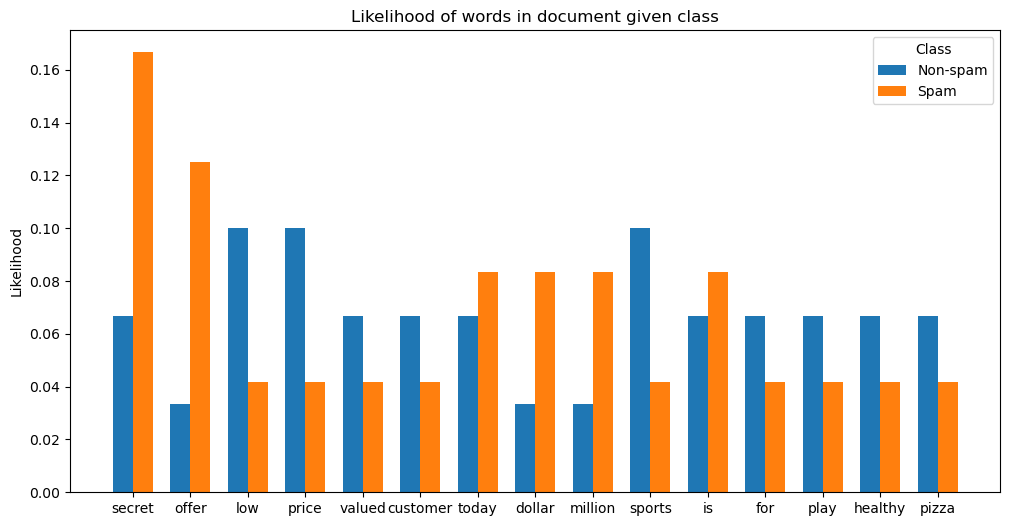

In [7]:
x = np.arange(len(vocab))
width = 0.35

# plot barplot of likelihood for each word
fig, ax = plt.subplots(figsize=(12, 6))
# given the not-spam class
rects1 = ax.bar(x - width/2, lk_word[0], width, label='Non-spam')
# and given the spam-class
rects2 = ax.bar(x + width/2, lk_word[1], width, label='Spam')

# add labels, title and legend to plot
ax.set_ylabel('Likelihood')
ax.set_xticks(x)
ax.set_xticklabels(vocab)
ax.set_title("Likelihood of words in document given class")
ax.legend(title="Class")

plt.show()

## Posterior in Multinomial Naive Bayes

Now we can predict whether any given email is spam or not. To do so we compute the posterior probability $\mathbb P(y|x)$ that a document $x$ is part of class $y$ following equation (5.6). In the context of Multinomial Naive Bayes, the posterior is given by:

$$
\mathbb P(y|x) \propto \mathbb P(y) ∏_{i=1}^p \mathbb P(x_i|y)^{x_i}
$$

As multiplication of many small values can lead to significant rounding errors, it's advantagous to carry out this computation in log space:

$$
\log \mathbb P(y|x) \propto \log \mathbb P(y) + \sum_{i=1}^p x_i \, \log \mathbb P(x_i|y)
$$

Note that the log-posterior is linear. We now implement a function that calculates the log-posterior using linear algebra and then returns the normalized (!) posterior probabilities.

In [8]:
# EDIT THIS FUNCTION
def predict_proba(X, prior, lk_word):
    """ Predict probability of class with Naive Bayes.

    Params:
      X (np.array): Features
      prior (np.array): Prior distribution of classes
      lk_word (np.array): Likelihood of words (features) to appear given class

    Returns:
      posteriors (np.array): Posterior distribution of documents
    """

    # compute log-posterior
    log_posterior = X @ np.log(lk_word).transpose() + np.log(prior) ## <-- SOLUTION

    # normalize to get full posterior distribution
    normalize_term = np.exp(log_posterior).sum(axis=1).reshape(-1, 1) ## <-- SOLUTION
    posteriors = np.exp(log_posterior) / normalize_term ## <-- SOLUTION

    return posteriors

We can now compute the posterior probabilities for our training data.

In [9]:
# compute full posterior distribution
posteriors = predict_proba(X, prior, lk_word)
print("Posteriors:\n", posteriors)

Posteriors:
 [[0.05382675 0.94617325]
 [0.10215483 0.89784517]
 [0.14578588 0.85421412]
 [0.96919027 0.03080973]
 [0.62098241 0.37901759]
 [0.80376766 0.19623234]
 [0.92474413 0.07525587]]


Finally, we can classify the documents in a binary fashion by asserting any data points $X$ to the class $y$ with the highest probability (called the *argmax choice*).

In [10]:
# EDIT THIS FUNCTION
def predict(X, prior, lk_word):
    """ Predict class with highest probability.

    Params:
      X (np.array): Features
      prior (np.array): Prior distribution of classes
      lk_word (np.array): Likelihood of words (features) to appear given class

    Returns:
      y_pred (np.array): Predicted target
    """

    # prediction given by argmax choice
    predicted_probabilities = predict_proba(X, prior, lk_word) ## <-- SOLUTION
    y_pred = predicted_probabilities.argmax(axis=1)  ## <-- SOLUTION

    return y_pred

Here, we take the same emails we used for training our Naive Bayes classifier to also to evaluate it. Usually, the evaluation happens on unseen emails (test data) and it is your task below to define a small test dataset. What are the predicted classes and what is the accuracy of the classifier?

In [11]:
# predict targets for training data with Naive Bayes
preds = predict(X, prior, lk_word) ## <-- SOLUTION
print("Predicted classes: ", preds) ## <-- SOLUTION
print(f'Train accuracy: {(preds==y).mean()}') ## <-- SOLUTION

Predicted classes:  [1 1 1 0 0 0 0]
Train accuracy: 1.0


#### Questions:
1. Define your own three short emails as a test set and evaluate our Naive Bayes classifier on it without re-training it on them. What do you observe?
2. What words have you included in emails of the test set that make them being classified as spam or not spam?

We define a small test set, where the challenge is that one spam message contains a word that classifier has not seen before in this class. Only because of the Laplace smoothing our classifier can still be applied to this case. (What would happen without Laplace smoothing?)

In [12]:
# define test spam emails
test_spam = [
    'secret today is secret',
    'secret pizza offer today',
]

# define test non-spam emails
test_not_spam = [
    'price for healthy valued customer is low',
]

In [13]:
# obtain test document-term matrix and target
X_test, y_test = prepare_spam_dataset(vocab, test_spam, test_not_spam, show_X=True)

,secret,offer,low,price,valued,customer,today,dollar,million,sports,is,for,play,healthy,pizza
0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,1,1,1,1,0,0,0,0,1,1,0,1,0


In [14]:
# obtain posterior probability on test set
print("Posteriors:\n", predict_proba(X_test, prior, lk_word))

Posteriors:
 [[0.12013139 0.87986861]
 [0.15400812 0.84599188]
 [0.97576657 0.02423343]]


In [15]:
# obtain prediction on test set
preds_test = predict(X_test, prior, lk_word)
print("Predicted classes: ", preds_test)
print(f'Test accuracy: {(preds_test==y_test).mean()}')

Predicted classes:  [1 1 0]
Test accuracy: 1.0


Our trained Multinomial Naive Bayes classifier performs well on the test set defined above.

3. Can you replicate your results using [sklearn](https://scikit-learn.org/stable/modules/naive_bayes.html)?
4. Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?

In [16]:
from sklearn.naive_bayes import MultinomialNB

# we use the Multinomial Naive Bayes model from sklearn
mnb = MultinomialNB(alpha=1, force_alpha=True)
mnb.fit(X, y)

# for comparison we print P(x_i|y)
print(np.exp(mnb.feature_log_prob_))

[[0.06666667 0.03333333 0.1        0.1        0.06666667 0.06666667
  0.06666667 0.03333333 0.03333333 0.1        0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667]
 [0.16666667 0.125      0.04166667 0.04166667 0.04166667 0.04166667
  0.08333333 0.08333333 0.08333333 0.04166667 0.08333333 0.04166667
  0.04166667 0.04166667 0.04166667]]


We observe that the Multinomial Naive Bayes implementation in sklearn leads to the same likelihood $\mathbb P(x_i|y)$. And also the posteriors match as we will see next.

In [17]:
# predicted probabilities are correct
print("Posteriors:\n", mnb.predict_proba(X))

# prediction is correct
print("\nPredicted classes:",mnb.predict(X))

Posteriors:
 [[0.05382675 0.94617325]
 [0.10215483 0.89784517]
 [0.14578588 0.85421412]
 [0.96919027 0.03080973]
 [0.62098241 0.37901759]
 [0.80376766 0.19623234]
 [0.92474413 0.07525587]]

Predicted classes: [1 1 1 0 0 0 0]
